In [1]:
import os, sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib.transforms import Affine2D
import matplotlib.path as mpath
import matplotlib.patches as mpatches
from scipy.stats import gaussian_kde
import seaborn as sns
import scanpy as sc
import torch
import tangram as tg
import json
import re
import glob

from matplotlib_scalebar.scalebar import ScaleBar

In [2]:
def rotate(p, origin=(0, 0), degrees=0):
    angle = np.deg2rad(degrees)
    R = np.array([[np.cos(angle), -np.sin(angle)],
                  [np.sin(angle),  np.cos(angle)]])
    o = np.atleast_2d(origin)
    p = np.atleast_2d(p)
    return np.squeeze((R @ (p.T-o.T) + o.T).T)

def normalize_rotated_y(df):
    y_min = df['rotated_y'].min()
    y_max = df['rotated_y'].max()
    df['rotated_y'] = (df['rotated_y'] - y_min) / (y_max - y_min)
    return df

def sanitize_filename(cell_type):
    # Replace invalid characters such as `/` and `\` with underscores
    return re.sub(r'[\\/*?:"<>|]', "_", cell_type)  

In [3]:
cell_type_colors = {
    'Astro': '#DFC27D',
    'Endo': '#FDBB84',
    'VLMC': '#B35806',
    'Oligo': '#35978F',
    'OPC': '#80CDC1',
    'Micro/PVM': '#7FBC41',
    
    'L2/3 IT': '#FB9A99',
    'L4 IT': '#FEE090', 
    'L5 IT': '#8C510A',
    'L5 ET': '#C51B7D',
    'L5/6 NP': '#9970AB',
    'L6 IT': '#EC7014',
    'L6 IT Car3': '#3F007D',
    'L6 CT': '#F1B6DA',
    'L6B': '#8E0152',
    
    'PVALB': '#66C2A5',
    'Chandelier':'#1D91C0',
    'SST': '#80B1D3',
    'SST CHODL': '#D6604D',
    'LAMP5': '#02818A',
    'LAMP5 LHX6': '#8C96C6',
    'VIP': '#4575B4',
    'SNCG': '#FB8072',
    'PAX6': '#BF812D'    
    }
    
IT_exc =['L2/3 IT', 'L4 IT', 'L5 IT', 'L6 IT', 'L6 IT Car3']
nonIT_exc= ['L5 ET', 'L5/6 NP', 'L6 CT', 'L6B']

MGE_inh=['PVALB', 'Chandelier', 'SST', 'SST CHODL']
CGE_inh=['LAMP5 LHX6', 'LAMP5', 'SNCG', 'VIP', 'PAX6']

nonNeu = ['OPC', 'Oligo', 'Astro', 'Endo', 'Micro/PVM', 'VLMC'] 
    
exc = IT_exc + nonIT_exc   
inh = MGE_inh + CGE_inh

# Make spatial plots in Figure 3A and fig S7
Every area include the cells from cortical and white matter region. However, the tissue sizes and orientations in different areas vary. So, we mannually cropped the ROI and rotate the the cropped ROI to subset cells from the pial surface to the white matter regions.Here is an example of making a whole-tissue spatial plot from ACC area and the table below summarizes the parameters we used in the rectangular selection to crop ROI in each brain area.
| area | figsize | xy | width | height | angle |
|------|---------|----|-------|--------|-------|
| ACC | (7,3) | (4000, 4000) | 4000 | 21000 | 285 |
| DFC | (4,6) | (13000, 3000) | 4000 | 16000 | 60 |
| FI | (6,7) | (2000, 2000) | 4000 | 24000 | 320 |
| M1C | (8,5) | (12000, 0) | 4000 | 16000 | 0 |
| S1C | (10, 6) | (20000, 2000) | 4000 | 12000 | 0 |
| MTG | (10, 6) | (15000, 3000) | 4000 | 10000 | 0 |
| A1C | (8, 6) | (5500, 4000) | 4000 | 18000 | 0|
| AnG | (6, 7) | (5000, 24000) | 4000 | 16000 | 235 |
| V1C | (10, 5) | (0, 10000)| 4000 | 28000 | 270 |

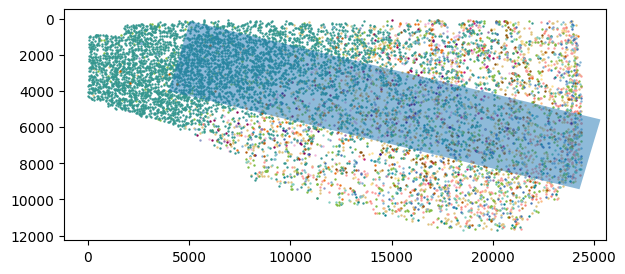

In [4]:
area = "ACC"

# load the datasets for specific area
df=pd.read_csv(f"BICCN_plots/whole_tissue/{area}_whole_tissue.csv")

# Make spatial plot for the whole tissue of this area in fig S7
fig, ax = plt.subplots(figsize = (7,3))

for cell_type, group in df.groupby("celltype_F"):
    if cell_type in cell_type_colors.keys():
        ax.scatter(group['x'], group['y'], label=cell_type, color=cell_type_colors[cell_type], s=0.5)
ax.invert_yaxis()


# retangular selection to crop ROI from cortical and white matter region for Fig 3
rect = Rectangle(xy=(4000, 4000), width=4000, height=21000, angle=285, alpha=0.5)
ax.add_patch(rect)
rect_path = mpath.Path(rect.get_corners())

# subset the cells in the ROI
df["selected"]=False
for i, cell in df.iterrows(): 
    if rect_path.contains_point((cell.x, cell.y)):
        df.loc[i, "selected"]=True
df_ROI = df[df["selected"]==True][["x", "y", "celltype_F"]]

# Rotate the ROI so that the y axis follows the pial surface at the top and white matter region at the bottom
The table below summarizes the parameters we used to rotate and make plots

| area | figsize | origin | degrees | y=np.linspace | extra notes |
|------|--------|---------|---------|---------------|-------------|
| ACC | (4.5 12) |(1000, 4000) | -285 | (8000, 28000, 1000) | NA |
| DFC | (4.5, 8) | (13000, 3000) | -60 | (3000, 16500, 1000) | df_ROI.rotated_y<=16500 |
| FI | (4.5,12) | (2000, 2000) | -320 | (1000, 26000, 1000) | need to flip vertically after plotting |
| M1C | (4.5, 12) | (12000, 0) | 0 | (0, 16000, 1000) | NA |
| S1C | (4.5, 6) | (20000, 2000) | 0 | (0, 16000, 1000) | need to flip vertically after plotting |
| MTG | (4.5, 6) | (20000, 2000) | 0 | (0, 14000, 1000) | NA|
| A1C | (4.5, 9) | (20000, 2000) | 0 | (3000, 22000, 1000) | NA |
| AnG | (4.5, 8) | (5000, 24000) |-235 | (24000, 37000, 1000)| df_ROI.rotated_y<=37000], need to flip vertically after plotting|
| V1C | (4.5, 14) | (0, 10000) | -270 | (10000, 38000, 1000) | flip vertically after plotting |


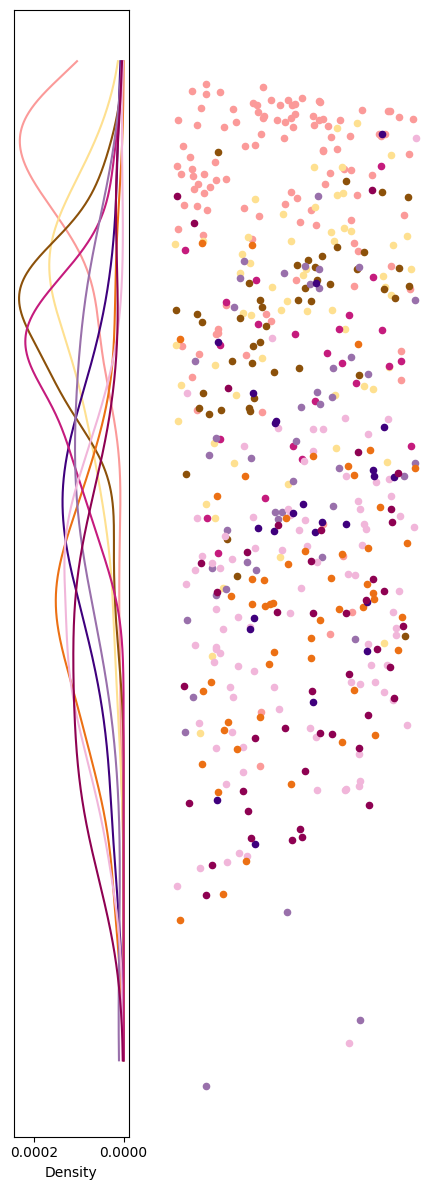

In [5]:
# Rotate the cells in ROI 
rotated_cells = rotate(p=list(zip(df_ROI.x, df_ROI.y)) , origin=(1000, 4000), degrees=-285)

df_ROI['rotated_x'] = rotated_cells[:, 0]
df_ROI['rotated_y'] = rotated_cells[:, 1]

# df_ROI=df_ROI[df_ROI.rotated_y>=8000] # further subset the cells so that the ROI include upper white matter
df_ROI.to_csv(f"BICCN_plots/ROI/{area}_ROI_spatial.csv") # Save the ROI for downstream analysis

# Make the spatial plots of subclass in each ROI
fig = plt.figure(figsize=(4.5,12))
ax1 = plt.subplot2grid((1,3), (0,0), colspan=1)
ax2 = plt.subplot2grid((1,3), (0,1), colspan=2, sharey=ax1)

# Use gaussian_kde to make the density plot along the cortical depth to make plots in Figure 3
for ct in exc:
    ct_locs = df_ROI[df_ROI['celltype_F']==ct]['rotated_y']
    kde = gaussian_kde(ct_locs)
    y=np.linspace(8000, 28000, 1000)
    ax1.plot(kde(y), y, label=cell_type, color=cell_type_colors[ct])

# Switch the x and y axes
ax1.invert_xaxis()
ax1.invert_yaxis()
ax1.set_yticks([0, 1])
ax1.set_xlabel('Density')                 
        

for cell_type, group in df_ROI.groupby('celltype_F'):
    if cell_type in exc: # switch the cell class here to make spatial plots of excitatory, inhibotory, and non-neuronal cells
        ax2.scatter(group.rotated_x, group.rotated_y, label=cell_type, color=cell_type_colors[cell_type], s=20.0)
        
ax2.invert_yaxis()
ax2.set_axis_off()
                 
plt.tight_layout()
plt.show()

# Merge all ROI dataframes and normalize the cortical depth along y axis

In [6]:
# Merge ROIs from all brain regions
input_dir = "BICCN_plots/ROI/"

# Create an empty list to store each region's dataframe
dataframes = []

# Loop through each CSV file in the directory
for filename in os.listdir(input_dir):
    if filename.endswith("_ROI_spatial.csv"):
        # Read the CSV file
        df = pd.read_csv(os.path.join(input_dir, filename))
        
        # Add a column to record the region name
        area_name = filename.replace("_ROI_spatial.csv", "")
        df["area"] = area_name
        
        # Append to the list
        dataframes.append(df)
# Concatenate all the dataframes together
allROI = pd.concat(dataframes, ignore_index=True)
        
# Although the cortical depth are aligned but the orientations of areas vary. So, we need to flipped the orientation of rotated_y so that pial surface at 0 and white matter at 1.0
flipped_regions = ['ACC', 'DFC', 'M1C', 'MTG', 'A1C']  # Define the list of regions where the rotated_y need to be flipped
# Invert the 'rotated_y' for these regions
allROI.loc[allROI['area'].isin(flipped_regions), 'rotated_y'] = 1 - allROI.loc[allROI['area'].isin(flipped_regions), 'rotated_y']


# Save the concatenated dataframe to a new CSV file
allROI.to_csv("BICCN_plots/allROI_prenorm_05112025.csv", index=False)

print(f"Concatenated data saved to: BICCN_plots/allROI_prenorm_05112025.csv")

Concatenated data saved to: BICCN_plots/allROI_prenorm_05112025.csv


In [7]:
allROI = pd.read_csv("BICCN_plots/allROI_prenorm_05112025.csv")

# Normalize the cortical depth by making rotated_y from 0 to 1 in each area
allROI = allROI.groupby('area').apply(normalize_rotated_y)

# Save allROI with normalized cortical depth as a CSV file
allROI.to_csv("./BICCN_plots/allROI_normalized_05112025.csv", index=False)

# Make density plots in Figure 3B and fig S8

In [8]:
allROI = pd.read_csv("./BICCN_plots/allROI_normalized_05112025.csv")
allROI = allROI.reset_index(drop=True)


area_order=['ACC', 'DFC', 'FI', 'M1C', 'S1C', 'MTG', 'A1C', 'AnG', 'V1C']
cell_types = ['L2/3 IT', 'L4 IT', 'L5 IT', 'L5 ET', 'L5/6 NP', 'L6 IT', 'L6 IT Car3', 'L6 CT', 'L6B',
            'PVALB', 'Chandelier', 'SST', 'SST CHODL', 'LAMP5', 'LAMP5 LHX6', 'VIP', 'SNCG', 'PAX6',
             'Astro', 'Endo', 'VLMC', 'Oligo', 'OPC', 'Micro/PVM']

# Loop through each cell type
for cell_type in cell_types:
    # Filter the DataFrame for the current cell type
    cell_type_df = allROI[allROI['celltype_F'] == cell_type]
    
    # Initialize a list to collect all density data for this cell type
    density_data = []
    
    # Create a new figure for each cell type
    plt.figure(figsize=(10, 6))
    
    # Loop through each region in the specified order and calculate the density for the current cell type
    for area in area_order:
        # Filter the group for the current region
        group = cell_type_df[cell_type_df['area'] == area]
        
        # Extract the normalized_rotated_y values
        y_values = group['rotated_y']
      
        # Check if there are enough data points to calculate density
        if len(y_values) > 1:
            # Calculate density using gaussian_kde
            kde = gaussian_kde(y_values)
            
            # Generate a range of y values from 0 to 1 for the plot
            y_range = np.linspace(0, 1, 1000)
            
            # Plot the density curve for the current region
            plt.plot(y_range, kde(y_range), label=f'Area: {area}')
            
             # Store the density data in a DataFrame
            area_density_df = pd.DataFrame({
                'cell_type': cell_type,
                'area': area,
                'y_range': y_range,
                'density': kde(y_range)
            })
            density_data.append(area_density_df)
    
    # Add labels and legend
    plt.ylabel('Density')
    plt.xlabel('Normalized cortical depth')
    plt.title(f'Density of {cell_type} cells along normalized cortical depth')
    plt.legend(title='Areas')

    
    # Sanitize the cell type name for a valid file name
    sanitized_cell_type = sanitize_filename(cell_type)
    
    # Save the plot as a PNG file, using the sanitized cell type as part of the file name
    plt.savefig(f'./BICCN_plots/05112025/{sanitized_cell_type}_density_plot.pdf', format='pdf', dpi=300)
    
    # # Close the plot to avoid memory issues during the loop
    plt.close()
    
    # Save density data of each cell type in each region  to a CSV
    combined_density_df = pd.concat(density_data, ignore_index=True)
    combined_density_df.to_csv(f'./BICCN_plots/05112025/{sanitized_cell_type}_density_data.csv', index=False)
    print(f'Saved density data for cell type {cell_type} to ./BICCN_plots/05112025/{sanitized_cell_type}_density_data.csv')

Saved density data for cell type L2/3 IT to ./BICCN_plots/05112025/L2_3 IT_density_data.csv
Saved density data for cell type L4 IT to ./BICCN_plots/05112025/L4 IT_density_data.csv
Saved density data for cell type L5 IT to ./BICCN_plots/05112025/L5 IT_density_data.csv
Saved density data for cell type L5 ET to ./BICCN_plots/05112025/L5 ET_density_data.csv
Saved density data for cell type L5/6 NP to ./BICCN_plots/05112025/L5_6 NP_density_data.csv
Saved density data for cell type L6 IT to ./BICCN_plots/05112025/L6 IT_density_data.csv
Saved density data for cell type L6 IT Car3 to ./BICCN_plots/05112025/L6 IT Car3_density_data.csv
Saved density data for cell type L6 CT to ./BICCN_plots/05112025/L6 CT_density_data.csv
Saved density data for cell type L6B to ./BICCN_plots/05112025/L6B_density_data.csv
Saved density data for cell type PVALB to ./BICCN_plots/05112025/PVALB_density_data.csv
Saved density data for cell type Chandelier to ./BICCN_plots/05112025/Chandelier_density_data.csv
Saved de

# Proximity analysis and plotting for Figure 3C and fig S8

In [9]:
allROI = pd.read_csv("./BICCN_plots/allROI_prenorm_05112025.csv")
allROI = allROI.reset_index(drop=True)

# Set radius and number of samples if not defined
radius = 352 # 100um
radius = 704 # 200um
num_samples = 100

# Get the unique cell types in 'celltype_F'
cell_types = allROI['celltype_F'].unique()

# Loop through each cell type and perform the proximity analysis
for cell_type in cell_types:
    # Filter merged_df for the current cell type
    cell_df = allROI[allROI['celltype_F'] == cell_type]

    # Get the unique regions for the current cell type
    areas = cell_df['area'].unique()

    # Prepare a list to store the results
    results = []

    # Loop through each region
    for area in areas:
        # Filter for the current region
        area_df = cell_df[cell_df['area'] == area]

        # Sample up to 100 cells from this region
        area_sample = area_df.sample(n=min(num_samples, len(area_df)), random_state=42)

        # Loop through each sampled cell
        for idx, sampled_cell in area_sample.iterrows():
            # Get the coordinates of the sampled cell
            x, y = sampled_cell['rotated_x'], sampled_cell['rotated_y']

            # Filter merged_df for cells in the same region
            same_area_cells = allROI[allROI['area'] == area]

            # Calculate the Euclidean distance between the sampled cell and all other cells in the same region
            distances = np.sqrt((same_area_cells['rotated_x'] - x) ** 2 + 
                                (same_area_cells['rotated_y'] - y) ** 2)

            # Filter cells within the radius (200 µm) and exclude the sampled cell itself
            nearby_cells = same_area_cells[distances <= radius]

            # Count the cell types within the 200 µm radius
            cell_type_counts = nearby_cells['celltype_F'].value_counts().to_dict()

            # Store the results
            results.append({
                'CellType': cell_type,
                'Sampled_x': x,
                'Sampled_y': y,
                'Area': area,
                'CellTypeCounts': cell_type_counts
            })

    # Convert the results to a DataFrame for this cell type
    proximity_analysis_df = pd.DataFrame(results)

    # Sanitize the cell type name for a valid file name
    sanitized_cell_type = sanitize_filename(cell_type)

    # Save the results to a CSV file for this cell type
    filename = f'./BICCN_plots/05112025/proximity_analysis/proximity_analysis_{sanitized_cell_type}_200um.csv'
    proximity_analysis_df.to_csv(filename, index=False)

    print(f'Saved proximity analysis for cell type {cell_type} to {filename}')

Saved proximity analysis for cell type L2/3 IT to ./BICCN_plots/05112025/proximity_analysis/proximity_analysis_L2_3 IT_200um.csv
Saved proximity analysis for cell type Oligo to ./BICCN_plots/05112025/proximity_analysis/proximity_analysis_Oligo_200um.csv
Saved proximity analysis for cell type Micro/PVM to ./BICCN_plots/05112025/proximity_analysis/proximity_analysis_Micro_PVM_200um.csv
Saved proximity analysis for cell type Astro to ./BICCN_plots/05112025/proximity_analysis/proximity_analysis_Astro_200um.csv
Saved proximity analysis for cell type LAMP5 to ./BICCN_plots/05112025/proximity_analysis/proximity_analysis_LAMP5_200um.csv
Saved proximity analysis for cell type OPC to ./BICCN_plots/05112025/proximity_analysis/proximity_analysis_OPC_200um.csv
Saved proximity analysis for cell type SNCG to ./BICCN_plots/05112025/proximity_analysis/proximity_analysis_SNCG_200um.csv
Saved proximity analysis for cell type VIP to ./BICCN_plots/05112025/proximity_analysis/proximity_analysis_VIP_200um.cs

In [12]:
# Define the desired order of regions and cell types
area_order = ['ACC', 'DFC', 'FI', 'M1C', 'S1C', 'MTG', 'A1C', 'AnG', 'V1C']  
cell_type_order = ['L2/3 IT', 'L4 IT', 'L5 IT', 'L5 ET', 'L5/6 NP', 'L6 IT', 'L6 IT Car3', 'L6 CT', 'L6B',
                   'PVALB', 'Chandelier', 'SST', 'SST CHODL', 'LAMP5', 'LAMP5 LHX6', 'VIP', 'SNCG', 'PAX6',
                   'Astro', 'Endo', 'VLMC', 'Oligo', 'OPC', 'Micro/PVM']  

# Define the colors for each cell type in the specified order
cell_type_colors = {
    'Astro': '#DFC27D', 'Endo': '#FDBB84', 'VLMC': '#B35806', 'Oligo': '#35978F', 'OPC': '#80CDC1', 'Micro/PVM': '#7FBC41',
    'L2/3 IT': '#FB9A99', 'L4 IT': '#FEE090', 'L5 IT': '#8C510A', 'L5 ET': '#C51B7D', 'L5/6 NP': '#9970AB', 'L6 IT': '#EC7014',
    'L6 IT Car3': '#3F007D', 'L6 CT': '#F1B6DA', 'L6B': '#8E0152', 'PVALB': '#66C2A5', 'Chandelier':'#1D91C0', 'SST': '#80B1D3',
    'SST CHODL': '#D6604D', 'LAMP5': '#02818A', 'LAMP5 LHX6': '#8C96C6', 'VIP': '#4575B4', 'SNCG': '#FB8072', 'PAX6': '#BF812D'    
}

# Directory where the CSV files are stored
input_dir = './BICCN_plots/05112025/proximity_analysis/'

# Loop through each file matching the pattern "proximity_analysis_*_200um.csv"
for file_path in glob.glob(os.path.join(input_dir, 'proximity_analysis_*_200um.csv')):
    # Use regular expression to extract the cell type name accurately
    match = re.search(r'proximity_analysis_(.+)_200um\.csv', os.path.basename(file_path))
    if match:
        cell_type = match.group(1)  # Extracted cell type name with original characters
        sanitized_cell_type = sanitize_filename(cell_type)  # Sanitize for filename

        # Load the CSV file for the current cell type
        proximity_analysis_df = pd.read_csv(file_path)

        # Initialize a list to store the aggregated counts for the current cell type
        aggregated_data = []

        # Aggregate counts for each row
        for _, row in proximity_analysis_df.iterrows():
            cell_type_counts = eval(row['CellTypeCounts'])  # Convert the string representation back to a dictionary
            area = row['Area']
            aggregated_data.append({'Area': area, **cell_type_counts})

        # Convert to DataFrame and perform aggregation
        aggregated_df = pd.DataFrame(aggregated_data)
        grouped_df = aggregated_df.groupby('Area').sum()
        grouped_df['Total_Count'] = grouped_df.sum(axis=1)
        percentage_df = grouped_df.div(grouped_df['Total_Count'], axis=0) * 100
        percentage_df = percentage_df.drop(columns='Total_Count').reset_index()

        # Reorder the regions and cell types
        percentage_df = percentage_df.set_index('Area').reindex(area_order)
        percentage_df = percentage_df[[ct for ct in cell_type_order if ct in percentage_df.columns]]
        
        # Save numbers for stacked barplot
        percentage_df.to_csv(f'./BICCN_plots/05112025/proximity_analysis/{sanitized_cell_type}_stacked_barplot_200um.csv', index=True)
        
        # Plotting
        percentage_df.plot(
            kind='bar', 
            stacked=True, 
            figsize=(12, 8), 
            color=[cell_type_colors[ct] for ct in cell_type_order if ct in percentage_df.columns]
        )

        # Add labels and title
        plt.xlabel('Area')
        plt.ylabel('Percentage (%)')
        plt.title(f'Percentage of cell types within 200µm of {cell_type} cells across areas')  # Use original cell type name in title
        plt.legend(title='Cell Types', bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.tight_layout()

        # Save the plot with the sanitized cell type name
        plt.savefig(f'./BICCN_plots/05112025/proximity_analysis/{sanitized_cell_type}_200um_neighbors.pdf', format='pdf', dpi=300)
        
        # Close the plot to free up memory
        plt.close()

        print(f'Saved plot for cell type {cell_type}')

Saved plot for cell type L5 ET
Saved plot for cell type SNCG
Saved plot for cell type PVALB
Saved plot for cell type PAX6
Saved plot for cell type L5_6 NP
Saved plot for cell type OPC
Saved plot for cell type LAMP5
Saved plot for cell type Endo
Saved plot for cell type SST CHODL
Saved plot for cell type L6 IT
Saved plot for cell type L6B
Saved plot for cell type L6 CT
Saved plot for cell type L4 IT
Saved plot for cell type L6 IT Car3
Saved plot for cell type VIP
Saved plot for cell type Micro_PVM
Saved plot for cell type L5 IT
Saved plot for cell type VLMC
Saved plot for cell type Oligo
Saved plot for cell type Chandelier
Saved plot for cell type Astro
Saved plot for cell type L2_3 IT
Saved plot for cell type SST
Saved plot for cell type LAMP5 LHX6
